In [1]:
import os
import json
import time
import sqlite3
from typing import List, Dict, Any, Set, Tuple
import pickle

In [2]:
from dotenv import load_dotenv
load_dotenv()

False

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

In [4]:
from ddgs import DDGS
import wikipedia
import yfinance as yf
import pandas as pd
import networkx as nx

In [5]:
try:
    from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
    _HAS_YAHOO_TOOL = True
except Exception:
    _HAS_YAHOO_TOOL = False

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
MODEL_NAME = "ibm/granite-4-h-tiny"
EVAL_MODEL_NAME = "qwen/qwen3-next-80b"
llm = ChatOpenAI(temperature=0.0, model_name=MODEL_NAME, base_url="http://localhost:1234/v1", api_key="lm-studio")
eval_llm = ChatOpenAI(temperature=0.0, model_name=EVAL_MODEL_NAME, base_url="http://localhost:1234/v1", api_key="lm-studio")

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_28386/3136323435.py:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.0, model_name=MODEL_NAME, base_url="http://localhost:1234/v1", api_key="lm-studio")


In [7]:
DB_PATH = "agentic_research_graph.db"

In [ ]:
NER_PROMPT = """You are a financial research assistant that extracts only *investment-relevant entities* from Yahoo Finance news summaries.

### Goal:
Identify entities that are directly useful for making investment or market research decisions.  
Ignore any historical, political, or unrelated entities.

---

### Rules:

1. **Extract entities** that represent potential *investment targets*, *market influencers*, or *financial signals*.

2. Valid `type` categories:
   - `Company` — publicly traded or investment-relevant private companies.
   - `StockTicker` — any stock symbols or exchange identifiers.
   - `Executive` — CEOs, CFOs, or leaders influencing company direction.
   - `FinancialInstrument` — stocks, ETFs, bonds, crypto, derivatives, etc.
   - `Event` — mergers, acquisitions, earnings reports, product launches, IPOs, layoffs, guidance updates.
   - `Metric` — financial terms like revenue, EPS, margins, debt ratio, growth %, etc.
   - `Value` — monetary or percentage values tied to financial performance.
   - `SectorOrIndustry` — technology, healthcare, energy, financials, etc.
   - `RegionOrMarket` — countries or regions affecting market exposure.
   - `MacroeconomicIndicator` — inflation, interest rate, GDP, unemployment (current or forward-looking).
   - `Organization` — financial regulators, exchanges, funds (e.g., SEC, IMF, BlackRock, Fed).
   - `ProductOrService` — key revenue drivers (e.g., iPhone, Azure, Tesla Model 3).

3. **Ignore entities** that:
   - Refer to history or law (e.g., “Act of 1600”).
   - Refer to general geography unless tied to a financial story.
   - Are generic words (like "market," "investor," "stock" with no specific context).
   - Don’t impact current or future investment outlooks.

4. **Be forward-looking.**
   - Prioritize recent or upcoming events, active companies, and living executives.
   - Filter out outdated or irrelevant mentions.
   
NEWS:
<<TEXT>>
"""

In [9]:
def extract_entities_with_llm(text: str, cap_chars: int = 3000) -> List[Dict[str, Any]]:
    """Run the LLM to extract entities from text. Caps text length for safety."""
    if not text:
        return []
    text_in = text if len(text) <= cap_chars else text[:cap_chars]
    prompt = NER_PROMPT.replace("<<TEXT>>", text_in)
    resp = llm([SystemMessage(content="You are a strict JSON-only extractor."), HumanMessage(content=prompt)])
    out = resp.content
    # Try to parse JSON strictly, else try to extract first JSON array.
    try:
        parsed = json.loads(out)
        if isinstance(parsed, list):
            return parsed
    except Exception:
        import re
        m = re.search(r"(\[.*\])", out, flags=re.S)
        if m:
            try:
                return json.loads(m.group(1))
            except Exception:
                pass
    return []

In [10]:
def ddg_search(query: str, max_results: int = 5):
    try:
        with DDGS() as ddg:
            results = [r for r in ddg.text(query, max_results=max_results)]
        return results
    except Exception as e:
        return [{"error": str(e)}]

In [11]:
def wikipedia_summary(query: str, sentences: int = 3):
    import wikipedia
    try:
        # Try exact page, then fallback to search
        try:
            return wikipedia.summary(query, sentences=sentences, auto_suggest=False)
        except wikipedia.exceptions.DisambiguationError as e:
            alt = e.options[0]
            return wikipedia.summary(alt, sentences=sentences)
        except wikipedia.exceptions.PageError:
            search = wikipedia.search(query)
            if search:
                return wikipedia.summary(search[0], sentences=sentences)
            raise
    except Exception as e:
        return f"WIKIPEDIA_ERROR: {e}"


In [12]:
def yahoo_finance_news_tool(ticker_or_query: str, limit: int = 8):
    from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
    import yfinance as yf
    try:
        tool = YahooFinanceNewsTool()
        if len(ticker_or_query) <= 5:  # ticker
            tk = yf.Ticker(ticker_or_query)
            company_name = tk.info.get("longName", ticker_or_query)
            out = tool.run(company_name)
        else:
            out = tool.run(ticker_or_query)
        if isinstance(out, list):
            return out[:limit]
        if isinstance(out, dict):
            return out.get("items", [out])[:limit]
        return [{"text": str(out)}]
    except Exception as e:
        return [{"error": str(e)}]


In [13]:
def init_db(db_path: str = DB_PATH) -> sqlite3.Connection:
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("""CREATE TABLE IF NOT EXISTS nodes (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    name TEXT UNIQUE,
                    depth INTEGER,
                    source TEXT,
                    notes TEXT
                )""")
    cur.execute("""CREATE TABLE IF NOT EXISTS edges (
                    id INTEGER PRIMARY KEY AUTOINCREMENT,
                    parent INTEGER,
                    child INTEGER,
                    relation TEXT
                )""")
    conn.commit()
    return conn

In [14]:
def add_node(conn: sqlite3.Connection, name: str, depth: int, source: str, notes: Dict[str, Any]) -> int:
    cur = conn.cursor()
    notes_json = json.dumps(notes, default=str)
    cur.execute("INSERT OR IGNORE INTO nodes (name, depth, source, notes) VALUES (?, ?, ?, ?)",
                (name, depth, source, notes_json))
    conn.commit()
    cur.execute("SELECT id FROM nodes WHERE name = ?", (name,))
    row = cur.fetchone()
    return int(row[0])

In [15]:
def add_edge(conn: sqlite3.Connection, parent_id: int, child_id: int, relation: str = "related"):
    cur = conn.cursor()
    cur.execute("INSERT INTO edges (parent, child, relation) VALUES (?, ?, ?)", (parent_id, child_id, relation))
    conn.commit()

In [16]:
def load_graph_from_db(conn: sqlite3.Connection) -> nx.DiGraph:
    G = nx.DiGraph()
    cur = conn.cursor()
    cur.execute("SELECT id, name, depth FROM nodes")
    for nid, name, depth in cur.fetchall():
        G.add_node(nid, name=name, depth=depth)
    cur.execute("SELECT parent, child, relation FROM edges")
    for parent, child, rel in cur.fetchall():
        G.add_edge(parent, child, relation=rel)
    return G

In [17]:
def planner_agent(question: str, ticker: str) -> List[str]:
    prompt = (
        f"You are an investment research planner. Given the user's question: \"{question}\" "
        f"and ticker: {ticker}, produce a concise numbered plan of 6 steps to research this question. "
        "Return the steps as a plain newline-separated list (1., 2., ...)."
    )
    resp = llm([SystemMessage(content="You are a concise planner."), HumanMessage(content=prompt)])
    text = resp.content.strip()
    print(text)
    # simple parse into steps
    steps = [line.strip() for line in text.splitlines() if line.strip()]
    return steps

In [18]:
def router_agent(content_snippet: str) -> str:
    """
    Determine which specialist should handle the given content snippet.
    Returns one of: 'news', 'earnings', 'market', 'policy', 'wiki', 'general'
    """
    prompt = (
        "You are a router that decides which specialist should handle a snippet.\n"
        "Given this short text, return only one word tag from: news, earnings, market, policy, wiki, general.\n\n"
        f"Text:\n{content_snippet[:1000]}\n"
    )
    resp = llm([SystemMessage(content="You are a single-word router."), HumanMessage(content=prompt)])
    tag = resp.content.strip().lower().split()[0]
    if tag not in {"news", "earnings", "market", "policy", "wiki", "general"}:
        return "general"
    return tag

In [19]:
def news_specialist_agent(news_item: Dict[str, Any]) -> Dict[str, Any]:
    """Analyze a single news item: produce summary, sentiment, named entities (via extractor)"""
    title = news_item.get("title") or news_item.get("headline") or news_item.get("text") or str(news_item)
    body = news_item.get("summary") or news_item.get("snippet") or news_item.get("text") or ""
    combined = f"TITLE: {title}\n\n{body}"
    # Summarize + sentiment + NER
    summary_prompt = (
        "You are a financial news analyst. Provide:\n"
        "1) one-line summary (<=25 words)\n"
        "2) sentiment: positive/neutral/negative\n"
        "Return JSON: {\"summary\":..., \"sentiment\":...}\n\n"
        f"News:\n{combined}"
    )
    resp = llm([SystemMessage(content="You are a JSON-only news analyzer."), HumanMessage(content=summary_prompt)])
    out = resp.content
    try:
        res = json.loads(out)
    except Exception:
        # attempt to parse lines
        res = {"summary": combined[:200], "sentiment": "neutral", "raw": out}
    # NER from combined text
    entities = extract_entities_with_llm(combined)
    res["entities"] = entities
    return res

In [20]:
def earnings_specialist_agent(ticker: str) -> Dict[str, Any]:
    """Analyze earnings/financials using yfinance"""
    try:
        tk = yf.Ticker(ticker)
        info = getattr(tk, "info", {}) or {}
        financials = getattr(tk, "financials", {}) or {}
        # ask LLM to summarize financials and flag signals
        fin_text = f"Company info: {json.dumps(info, default=str)[:2000]}\n\nFinancials (truncated): {str(financials)[:2000]}"
        prompt = (
            "You are an earnings specialist. Read the company info and financials and return a short JSON:\n"
            "{\"summary\":\"...\",\"key_signals\":[\"...\"], \"risk_flags\":[\"...\"]}\n\n"
            f"{fin_text}"
        )
        resp = llm([SystemMessage(content="You are a financial summarizer."), HumanMessage(content=prompt)])
        try:
            return json.loads(resp.content)
        except Exception:
            return {"summary": resp.content}
    except Exception as e:
        return {"error": str(e)}

In [21]:
def market_specialist_agent(ticker: str, context_snippet: str = "") -> Dict[str, Any]:
    """
    Higher-level market analysis: macro, sector strength, comparables
    Uses ddg_search for sector news and LLM for summarization.
    """
    # quick sector search
    sector_search = ddg_search(f"{ticker} sector performance outlook", max_results=4)
    prompt = (
        "You are a market analyst. Given the snippets below, produce JSON:\n"
        "{\"summary\":\"...\",\"macro_drivers\":[\"...\"],\"sector_trend\":\"up/flat/down\"}\n\n"
        f"Snippets: {sector_search}\n\nContext: {context_snippet[:800]}"
    )
    resp = llm([SystemMessage(content="You are a market analyst."), HumanMessage(content=prompt)])
    try:
        return json.loads(resp.content)
    except Exception:
        return {"summary": resp.content}

In [22]:
def policy_specialist_agent(entity: str) -> Dict[str, Any]:
    """Search for government policy / subsidy terms related to the entity and summarize implication"""
    gov_search = ddg_search(f"{entity} government policy subsidy regulation", max_results=4)
    prompt = (
        "You are a policy analyst. Given search results, summarize whether governments are promoting or restricting growth, "
        "and list any named policies found. Return JSON: {\"promotion\":true/false, \"policies\":[...], \"notes\":\"...\"}\n\n"
        f"Results: {gov_search}"
    )
    resp = llm([SystemMessage(content="You are a policy analyst."), HumanMessage(content=prompt)])
    try:
        return json.loads(resp.content)
    except Exception:
        return {"summary": resp.content, "raw_results": gov_search}

In [23]:
VISITED_ENTITIES: Set[str] = set()

In [24]:
class Node:
    def __init__(self, name: str, source: str, depth: int):
        self.name = name
        self.source = source
        self.depth = depth
        self.children: list["Node"] = []
        self.notes: dict = {}

    def to_dict(self):
        return {
            "name": self.name,
            "source": self.source,
            "depth": self.depth,
            "notes": self.notes,
            "children": [c.to_dict() for c in self.children],
        }


In [25]:
def investigate_entity(entity_name: str, depth: int, max_depth: int, conn: sqlite3.Connection) -> Node:
    node = Node(entity_name, source='entity', depth=depth)
    name_key = entity_name.strip().lower()
    print(f"Visiting entity {entity_name} at depth {depth}")
    if depth >= max_depth or name_key in VISITED_ENTITIES:
        return node
    VISITED_ENTITIES.add(name_key)

    # For depth == 0: we already ran Yahoo News at root
    # For depth >= 1: skip Yahoo News and rely on open web + Wikipedia
    if depth == 0:
        # Already handled in root level, but you can include fallback here if needed
        pass
    else:
        # Internet-based exploration (for non-ticker entities)
        ddg_res_raw = ddg_search(entity_name, max_results=5)
        try:
            ddg_res = json.loads(ddg_res_raw)
        except Exception:
            ddg_res = [{"error": ddg_res_raw}]
        node.notes['ddg'] = ddg_res

        # Wikipedia summary
        wiki = wikipedia_summary(entity_name)
        node.notes['wikipedia'] = wiki

        # Government/policy relevance
        gov_search_raw = ddg_search(f"{entity_name} government policy", max_results=3)
        try:
            gov_search = json.loads(gov_search_raw)
        except Exception:
            gov_search = [{"error": gov_search_raw}]
        node.notes['gov_search'] = gov_search

    # Aggregate for NER extraction
    snippets = []
    if node.notes.get('ddg'):
        for r in node.notes['ddg'][:5]:
            if isinstance(r, dict):
                snippets.append(r.get('body') or r.get('snippet') or r.get('title') or '')
            else:
                snippets.append(str(r))
    agg_text = '\n'.join(snippets) + '\n' + node.notes.get('wikipedia', '')
    entities = extract_entities_with_llm(agg_text)
    node.notes['extracted_entities'] = entities

    # Store node
    node_id = add_node(conn, entity_name, depth, 'investigate_entity', node.notes)

    # Recursive exploration for newly found entities
    for ent in entities:
        child_name = ent.get('name')
        if child_name and isinstance(child_name, str):
            child_node = investigate_entity(child_name, depth + 1, max_depth, conn)
            child_id = add_node(conn, child_node.name, child_node.depth, child_node.source, child_node.notes)
            add_edge(conn, node_id, child_id)
            node.children.append(child_node)

    return node


In [26]:
def evaluator_agent(tree_json: Dict[str, Any], question: str, ticker: str) -> Dict[str, Any]:
    """
    Produce a structured recommendation (decision: BUY/HOLD/SELL, confidence 1-10, reasons [3]).
    Returns a JSON-like dict.
    """
    # Limit tree size in prompt to avoid token explosion
    tree_str = json.dumps(tree_json.to_dict())[:11000]
    prompt = (
        "You are an experienced investment analyst. Given the research tree (JSON truncated) and the user's question, "
        "produce a JSON with fields: decision (BUY/HOLD/SELL), confidence (1-10 integer), reasons (array of 3 short sentences).\n\n"
        f"Question: {question}\nTicker: {ticker}\nResearchTree: {tree_str}\n"
    )
    resp = eval_llm([SystemMessage(content="You are an objective analyst."), HumanMessage(content=prompt)])
    out = resp.content
    try:
        return json.loads(out)
    except Exception:
        import re
        m = re.search(r"(\{.*\})", out, flags=re.S)
        if m:
            try:
                return json.loads(m.group(1))
            except Exception:
                pass
        return {"raw": out}

In [27]:
def optimizer_agent(prev_recommendation: Dict[str, Any], tree_json: Dict[str, Any],
                    question: str, ticker: str) -> Tuple[Dict[str, Any], bool]:
    """
    If evaluator confidence is low (<6) or reasons seem weak, ask the LLM to propose 1-2 extra research tasks
    (e.g., deeper ddg searches, check SEC filings, check specific policies) and return them.
    Returns (instructions, should_run) where instructions is a dict describing new work and should_run boolean.
    """
    confidence = prev_recommendation.get("confidence")
    if isinstance(confidence, int) and confidence >= 6:
        return ({"note": "Confidence adequate; no extra steps."}, False)

    prompt = (
        "You are an optimizer. Given a previous recommendation and the research tree, propose 2 concrete extra research steps "
        "that could improve confidence (e.g., search specific filings, deep-dive keywords, check recent earnings call transcript).\n"
        "Return JSON: {\"extra_steps\": [\"step1\", \"step2\"]}\n\n"
        f"PrevRecommendation: {json.dumps(prev_recommendation)}\nTree: {json.dumps(tree_json)[:8000]}"
    )
    resp = llm([SystemMessage(content="You are a research optimizer."), HumanMessage(content=prompt)])
    out = resp.content
    try:
        parsed = json.loads(out)
        steps = parsed.get("extra_steps", [])
        return ({"extra_steps": steps}, True if steps else False)
    except Exception:
        return ({"raw": out}, False)

In [28]:
def run_agentic_pipeline(question: str, ticker: str, max_depth: int = 3, optimizer_rounds: int = 1) -> Dict[str, Any]:
    """
    Agentic pipeline:
      1) Planner generates a plan (for display only)
      2) Investigate recursively using Router + Specialists + Extractor (persists in SQLite)
      3) Evaluator produces recommendation
      4) Optimizer may propose extra steps; if so, run them and re-evaluate
    """
    conn = init_db(DB_PATH)
    graph = nx.DiGraph()
    # Reset visited set (so multiple runs in same session behave)
    global VISITED_ENTITIES
    VISITED_ENTITIES = set()

    # Planner
    plan_steps = planner_agent(question, ticker)

    # Root investigation
    root_tree = investigate_entity(ticker, depth=0, max_depth=max_depth, conn=conn)

    # Evaluate
    recommendation = evaluator_agent(root_tree, question, ticker)

    # Optimizer loop
    for r in range(optimizer_rounds):
        opt_instructions, should_run = optimizer_agent(recommendation, root_tree, question, ticker)
        if not should_run:
            break
        # For each extra step, do a best-effort action: parse the instruction string and run a ddg or wiki search
        extra_steps = opt_instructions.get("extra_steps", [])
        for step in extra_steps:
            # Simple heuristic: if mentions 'SEC' or 'filing', fetch SEC filings (we'll call ddg)
            if "sec" in step.lower() or "filing" in step.lower():
                sec_res = ddg_search(f"{ticker} SEC filings", max_results=5)
                # attach to DB root node notes
                root_tree.setdefault("notes", {})
                root_tree["notes"].setdefault("optimizer_extras", []).append({"step": step, "results": sec_res})
            else:
                # run ddg for the step
                ddg_r = ddg_search(step, max_results=5)
                root_tree.setdefault("notes", {})
                root_tree["notes"].setdefault("optimizer_extras", []).append({"step": step, "results": ddg_r})
        # After running extra steps, re-evaluate
        recommendation = evaluator_agent(root_tree, question, ticker)

    # Save final networkx graph to a file or return as object
    with open("investigation_graph.gpickle", "wb") as f:
        pickle.dump(graph, f)

    return {
        "plan": plan_steps,
        "tree": root_tree,
        "recommendation": recommendation,
        "db_path": DB_PATH,
        "nx_graph_path": "investigation_graph.gpickle"
    }

In [29]:
question = "Should I buy Apple stock today?"
ticker = "AAPL"

In [30]:
output = run_agentic_pipeline(question, ticker, max_depth=3, optimizer_rounds=1)

/var/folders/d9/34q0n1js31x765w00t009x6c0000gn/T/ipykernel_28386/1096954470.py:7: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  resp = llm([SystemMessage(content="You are a concise planner."), HumanMessage(content=prompt)])


Here is a concise numbered plan of 6 steps to research whether you should buy Apple stock (AAPL) today:

1. Analyze AAPL's recent price performance and trading volume over various timeframes.
2. Review AAPL's financial statements, focusing on revenue growth, profitability, and cash flow trends.
3. Assess AAPL's competitive position within the technology sector and its market share dynamics.
4. Evaluate macroeconomic factors that may impact AAPL's stock price, such as interest rates, inflation, and consumer spending.
5. Examine analyst ratings, target prices, and consensus recommendations for AAPL from reputable financial institutions.
6. Consider your personal investment goals, risk tolerance, and portfolio diversification before making a decision on whether to buy AAPL stock today.
Visiting entity AAPL at depth 0
Visiting entity Apple Inc. at depth 1
Visiting entity Apple Inc. at depth 2
Visiting entity Steve Jobs at depth 2
Visiting entity Steven Paul Jobs at depth 3
Visiting entity 

In [31]:
for s in output["plan"]:
    print(s)

Here is a concise numbered plan of 6 steps to research whether you should buy Apple stock (AAPL) today:
1. Analyze AAPL's recent price performance and trading volume over various timeframes.
2. Review AAPL's financial statements, focusing on revenue growth, profitability, and cash flow trends.
3. Assess AAPL's competitive position within the technology sector and its market share dynamics.
4. Evaluate macroeconomic factors that may impact AAPL's stock price, such as interest rates, inflation, and consumer spending.
5. Examine analyst ratings, target prices, and consensus recommendations for AAPL from reputable financial institutions.
6. Consider your personal investment goals, risk tolerance, and portfolio diversification before making a decision on whether to buy AAPL stock today.


In [32]:
print(json.dumps(output["recommendation"], indent=2))

{
  "decision": "BUY",
  "confidence": 8,
  "reasons": [
    "Apple Inc. remains the world's largest company by market capitalization at over $3.47 trillion, with dominant positions in smartphones, services, and wearables driving consistent revenue growth.",
    "The company has a loyal customer base, strong brand value, and a proven track record of innovation with products like iPhone, iPad, and Apple Silicon chips that sustain long-term competitive advantage.",
    "Despite regulatory scrutiny, Apple's ecosystem lock-in and services growth (iCloud, Apple Music, App Store) provide resilient cash flows, making it a top-tier defensive tech stock in uncertain markets."
  ]
}


In [34]:
tree_data = output["tree"].to_dict() if hasattr(output["tree"], "to_dict") else output["tree"]

In [36]:
with open("research_tree.json", "w") as f:
    json.dump(tree_data, f, indent=2)

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

In [41]:
with open("investigation_graph.gpickle", "rb") as f:
    G = pickle.load(f)


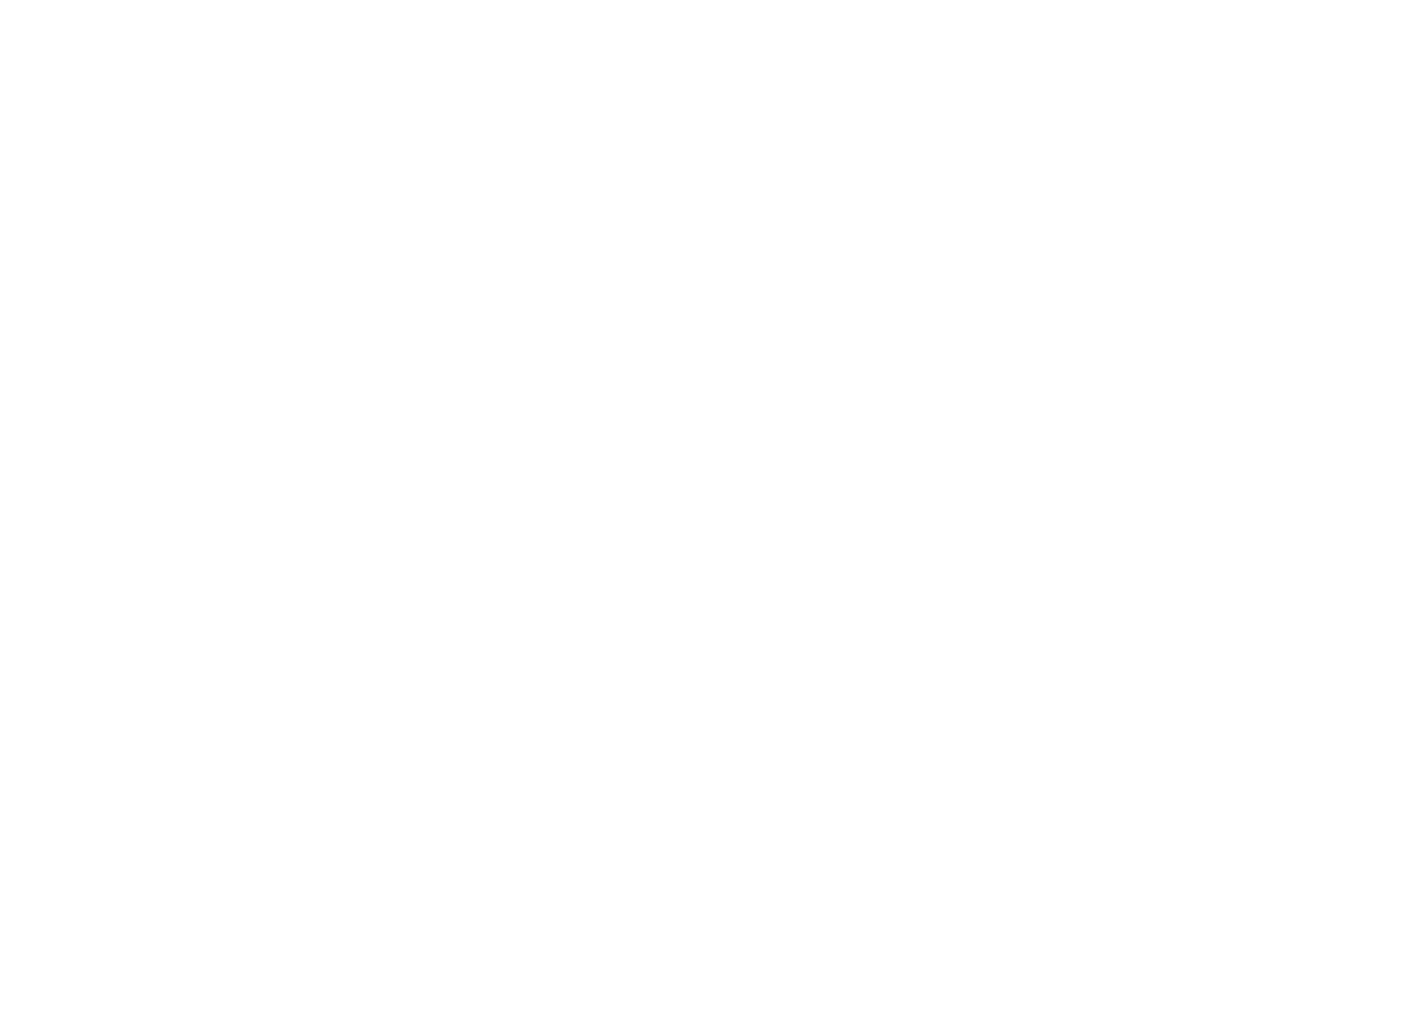

In [43]:
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.25)
nx.draw(G, pos, with_labels=False, node_size=50, alpha=0.6)
nx.draw_networkx_labels(G, pos, labels=nx.get_node_attributes(G, 'name'), font_size=7)
plt.show()

In [45]:
import sqlite3
import networkx as nx

In [46]:
conn = sqlite3.connect("agentic_research_graph.db")
G = nx.DiGraph()

In [47]:
for row in conn.execute("SELECT id, name, depth FROM nodes"):
    G.add_node(row[0], label=row[1], depth=row[2])

In [51]:
for row in conn.execute("SELECT parent, child FROM edges"):
    G.add_edge(row[0], row[1])

In [52]:
conn.close()

In [53]:
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

Nodes: 113 Edges: 162


In [54]:
import matplotlib.pyplot as plt

In [55]:
depths = nx.get_node_attributes(G, 'depth')
colors = [depths[n] for n in G.nodes()]

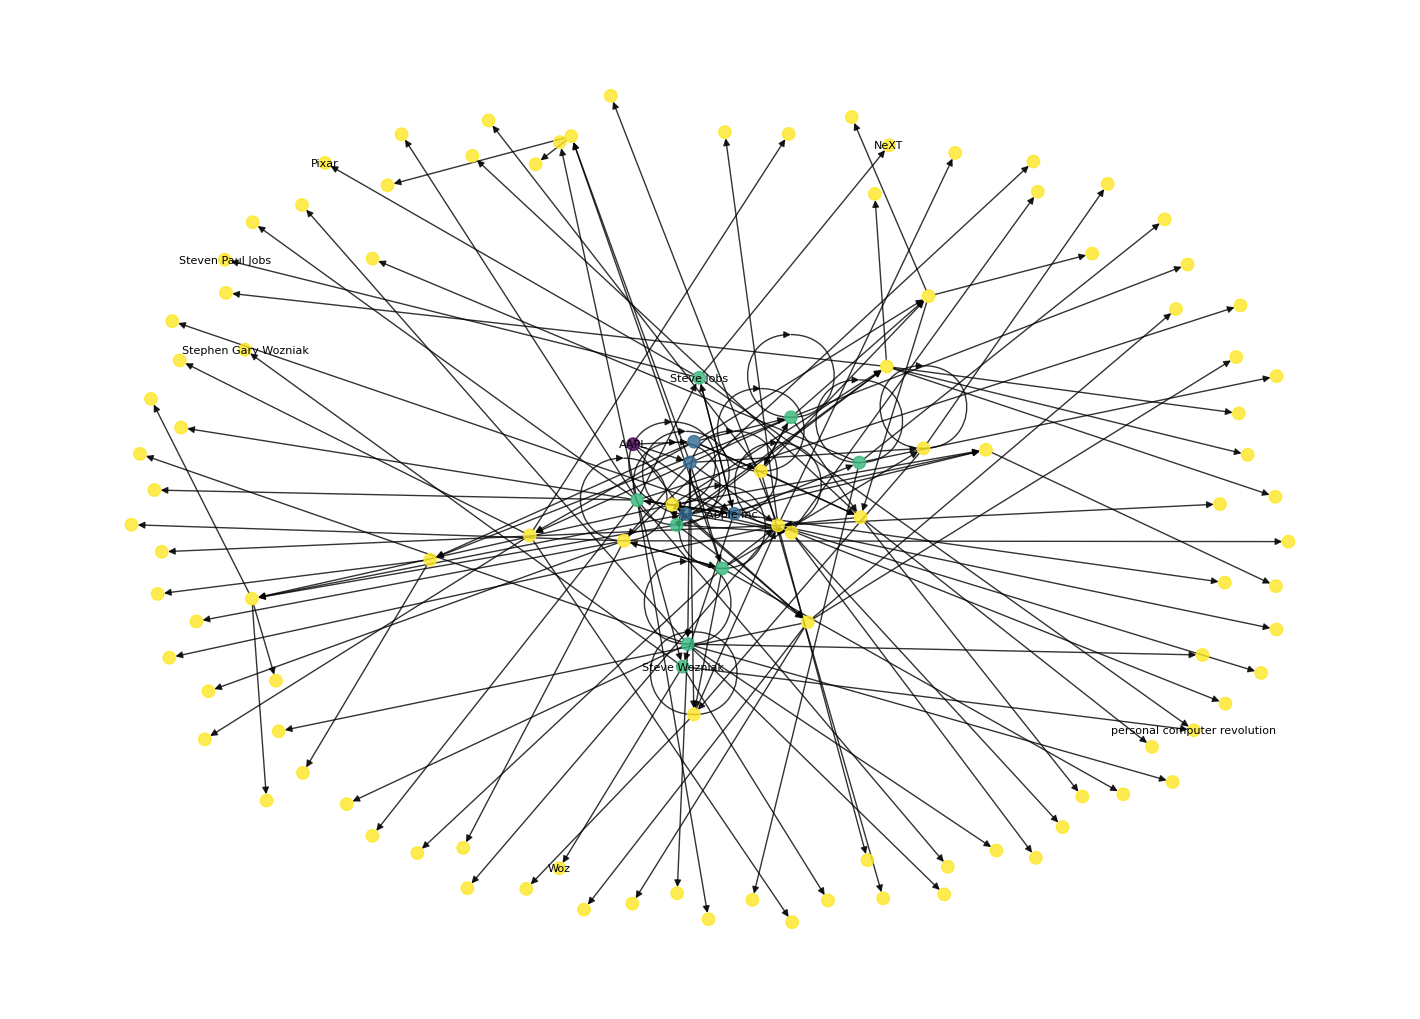

In [57]:
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.35, seed=42)
nx.draw(
    G, pos,
    node_color=colors,
    cmap=plt.cm.viridis,
    with_labels=False,
    node_size=80,
    alpha=0.8
)
labels = {n: G.nodes[n].get('label', '') for n in list(G.nodes())[:10]}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_color='black')
plt.show()

In [58]:
nx.write_gexf(G, "agentic_graph.gexf")